# ML HidroPrev com a API Keras

In [1]:
# Bibliotecas
import eda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import keras
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

2025-07-24 00:16:25.211839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753330585.223385 2498928 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753330585.226870 2498928 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753330585.237196 2498928 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753330585.237206 2498928 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753330585.237208 2498928 computation_placer.cc:177] computation placer alr

### Tratando os dados

In [ ]:
dados_manaus = eda.data_processing('Cotas extraidas', '1903-01-01', '2024-12-31', ['dados_diarios_estacao_14990000.csv'])
dados_manaus

,14990000
Data,
1903-01-01,1914.0
1903-01-02,1921.0
1903-01-03,1924.0
1903-01-04,1926.0
1903-01-05,1929.0
...,...
2024-12-27,1751.0
2024-12-28,1769.0
2024-12-29,1785.0


In [3]:
dados_manaus.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44561 entries, 1903-01-01 to 2024-12-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   14990000  44561 non-null  float64
dtypes: float64(1)
memory usage: 696.3 KB


### Machine Learning

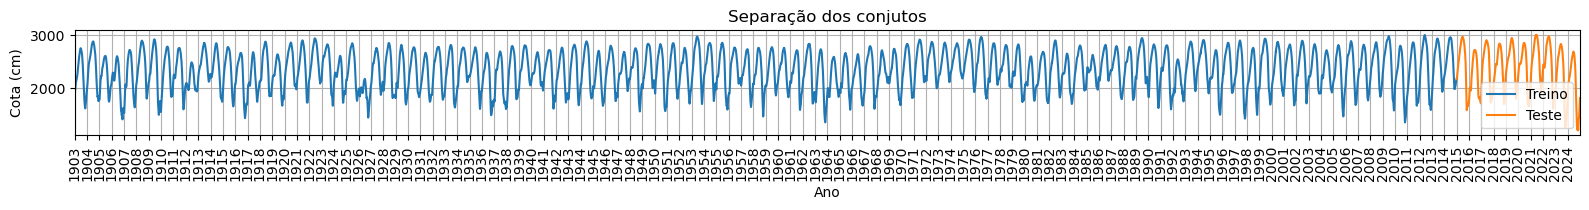

In [3]:
# Separação do conjunto
treino = dados_manaus[:'2014-12-31']
teste = dados_manaus['2015-01-01':]

plt.figure(figsize=(16, 2))
plt.plot(treino['14990000'])
plt.plot(teste['14990000'])
plt.legend(['Treino', 'Teste'])
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Ano')
plt.ylabel('Cota (cm)')
plt.xticks(rotation=90)
plt.xlim(dados_manaus.index[0], dados_manaus.index[-1])
plt.tight_layout()
plt.title('Separação dos conjutos')
plt.show()

##### MLP

In [5]:
# Criação de batches
window_length = 365
shifts = np.arange(1,window_length+1)
# Create a dictionary of time-shifted data
x_shifts = {'lag_{}'.format(ii): treino['14990000'].shift(ii) for ii in shifts}
# Convert the shifts into a dataframe
x_shifts = pd.DataFrame(x_shifts)
x_shifts.fillna(0, inplace=True)

In [6]:
mlp = keras.models.Sequential([
    keras.layers.Input(shape=x_shifts.shape[1:]),
    keras.layers.Dense(11, activation='relu'),
    keras.layers.Dense(11, activation='relu'),
    keras.layers.Dense(1)
])

I0000 00:00:1753204694.324712  805194 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10151 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


In [7]:
mlp.compile(loss='mse', metrics=[keras.metrics.R2Score()], optimizer='adam')

In [8]:
mlp.fit(x_shifts.iloc[window_length:], treino['14990000'][window_length:], epochs=1000, verbose=2)

Epoch 1/1000


I0000 00:00:1753204700.837828  805470 service.cc:152] XLA service 0x766bc0006860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753204700.837870  805470 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2025-07-22 13:18:20.854267: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753204700.929427  805470 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753204701.397551  805470 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1267/1267 - 3s - 3ms/step - loss: 61053.0625 - r2_score: 0.5229
Epoch 2/1000
1267/1267 - 1s - 996us/step - loss: 3205.5256 - r2_score: 0.9749
Epoch 3/1000
1267/1267 - 1s - 1ms/step - loss: 1679.9805 - r2_score: 0.9869
Epoch 4/1000
1267/1267 - 1s - 1ms/step - loss: 1589.9526 - r2_score: 0.9876
Epoch 5/1000
1267/1267 - 1s - 1ms/step - loss: 1503.7330 - r2_score: 0.9882
Epoch 6/1000
1267/1267 - 1s - 1ms/step - loss: 1132.4312 - r2_score: 0.9911
Epoch 7/1000
1267/1267 - 1s - 990us/step - loss: 1245.0900 - r2_score: 0.9903
Epoch 8/1000
1267/1267 - 1s - 983us/step - loss: 1018.9219 - r2_score: 0.9920
Epoch 9/1000
1267/1267 - 1s - 947us/step - loss: 869.7447 - r2_score: 0.9932
Epoch 10/1000
1267/1267 - 1s - 991us/step - loss: 832.1306 - r2_score: 0.9935
Epoch 11/1000
1267/1267 - 1s - 994us/step - loss: 836.4932 - r2_score: 0.9935
Epoch 12/1000
1267/1267 - 1s - 979us/step - loss: 720.7919 - r2_score: 0.9944
Epoch 13/1000
1267/1267 - 1s - 896us/step - loss: 660.4890 - r2_score: 0.9948
Epoch 14/

In [10]:
test_predictions = []
first_eval_batch = treino['14990000'][-window_length:].values
current_batch = first_eval_batch.reshape((1, window_length))

for i in range(len(teste)):
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = mlp.predict(current_batch, verbose=0)[0][0]
    # store prediction
    test_predictions.append(current_pred)
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:],[[current_pred]],axis=1)

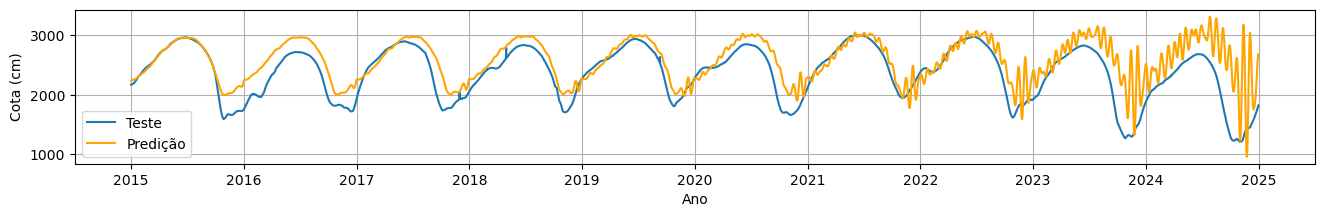

In [12]:
y_pred = pd.DataFrame(test_predictions)
y_pred.index = teste['14990000'].index

plt.figure(figsize=(16, 2))
plt.plot(teste['14990000'], label='Teste')
plt.plot(y_pred, label='Predição', color='orange')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True)
plt.xlabel('Ano')
plt.ylabel('Cota (cm)')
plt.legend()
plt.show()

In [13]:
r2_score(teste['14990000'], y_pred)

0.424419996883586

##### LSTM

In [4]:
def create_multi_step_dataset(series, janela, n_steps):
    X, y = [], []
    for i in range(len(series) - janela - n_steps + 1):
        X.append(series[i:i+janela])
        y.append(series[i+janela:i+janela+n_steps])
    return np.array(X), np.array(y)


In [5]:
janela = 30
steps = 30

X, y = create_multi_step_dataset(dados_manaus['14990000'].values, janela, steps)

x_train = X[:treino.shape[0]-janela]
y_train = y[:treino.shape[0]-janela]

x_test = X[treino.shape[0]-janela:]
y_test = y[treino.shape[0]-janela:]

x_scale = MinMaxScaler()
x_train = x_scale.fit_transform(x_train)
x_test = x_scale.transform(x_test)

y_scale = MinMaxScaler()
y_train = y_scale.fit_transform(y_train)
y_test = y_scale.transform(y_test)

In [6]:
lstm = keras.models.Sequential([
    keras.layers.Input(shape=(janela, 1)),
    keras.layers.LSTM(150),
    keras.layers.Dense(steps)
])

lstm.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanAbsoluteError()])

lstm.fit(x_train, y_train, epochs=50)

I0000 00:00:1753330610.521498 2498928 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10151 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/50


I0000 00:00:1753330612.066385 2499207 cuda_dnn.cc:529] Loaded cuDNN version 90300


1278/1278 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0196 - mean_absolute_error: 0.0783
Epoch 2/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0018 - mean_absolute_error: 0.0300
Epoch 3/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0016 - mean_absolute_error: 0.0277
Epoch 4/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0014 - mean_absolute_error: 0.0255
Epoch 5/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0012 - mean_absolute_error: 0.0236
Epoch 6/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0011 - mean_absolute_error: 0.0221
Epoch 7/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 9.7308e-04 - mean_absolute_error: 0.0206
Epoch 8/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 9.1164e-04 - mean_absolute_error: 0.0198
Epoch 9/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 9.0357e-04 - mean_absolute_error: 0.0195
Epoch 10/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 8.9112e-04 - mean_absolute_error: 0.0194
Epoc

In [12]:
pred = lstm.predict(x_test)

  1/114 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [8]:
pred_inv = y_scale.inverse_transform(pred)
y_test_inv = y_scale.inverse_transform(y_test)

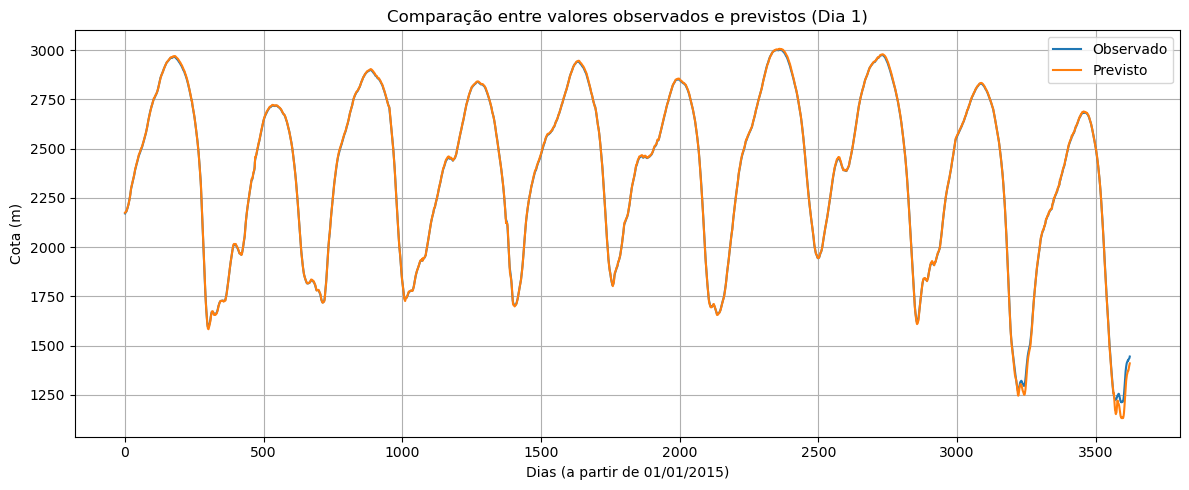

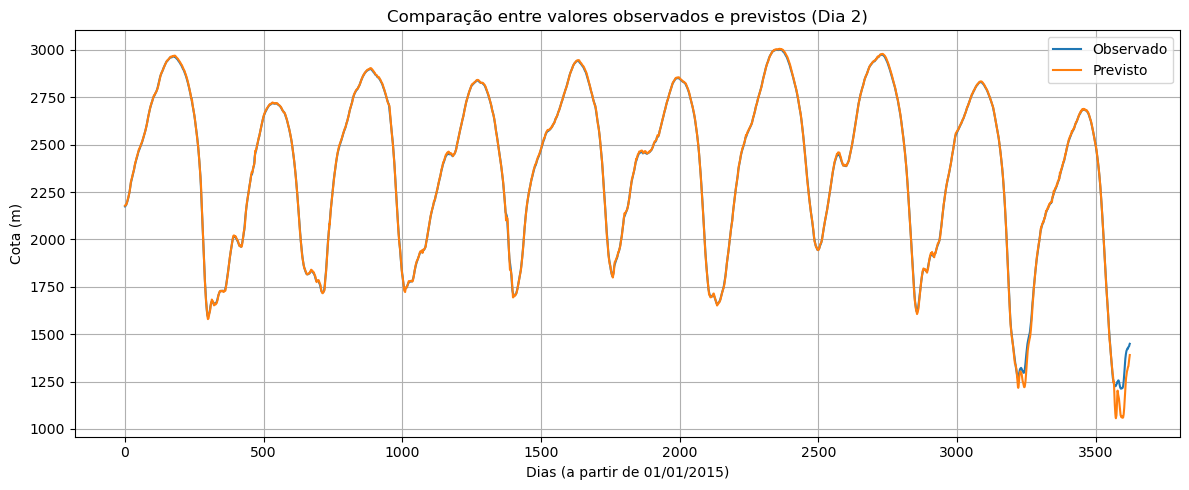

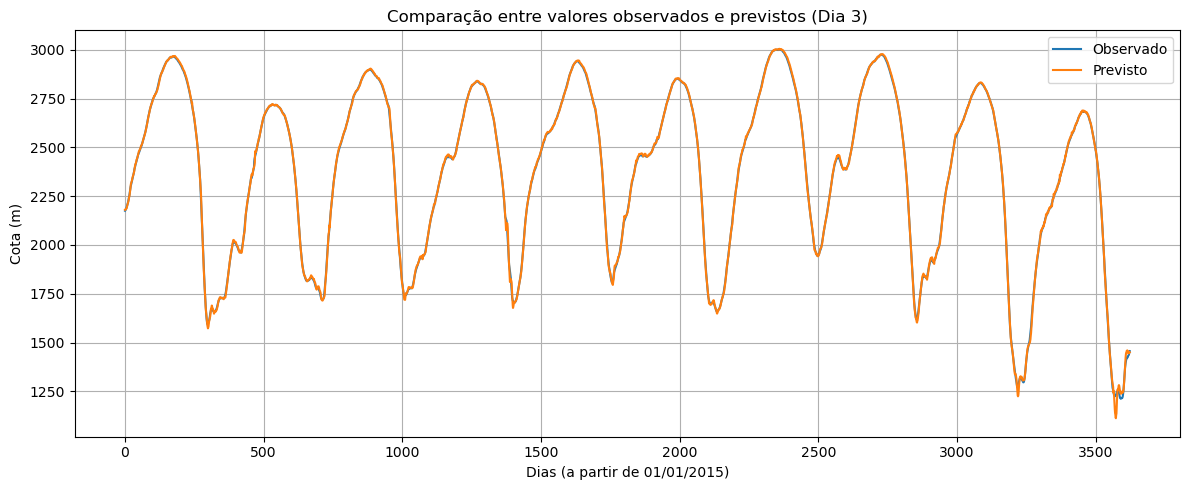

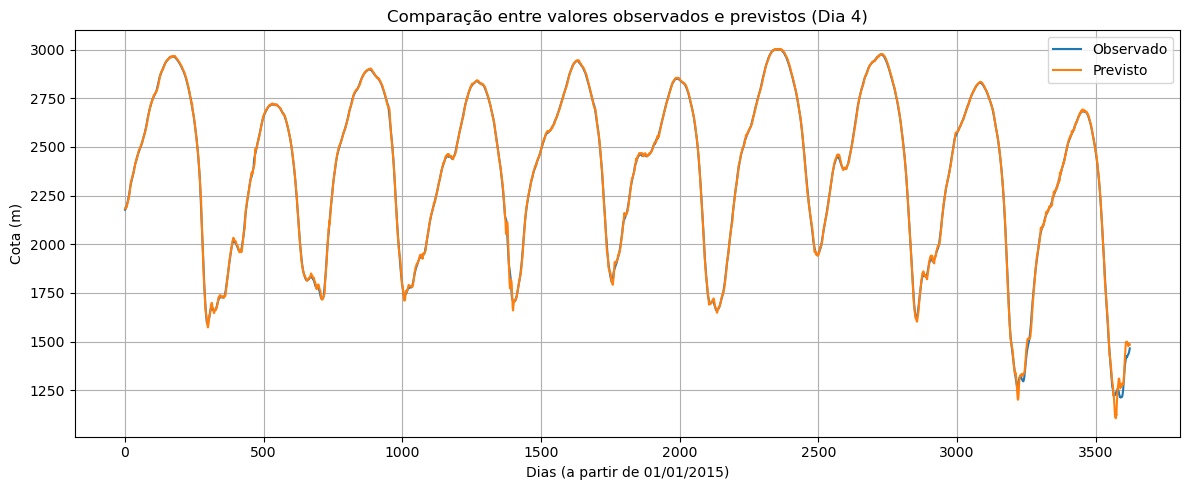

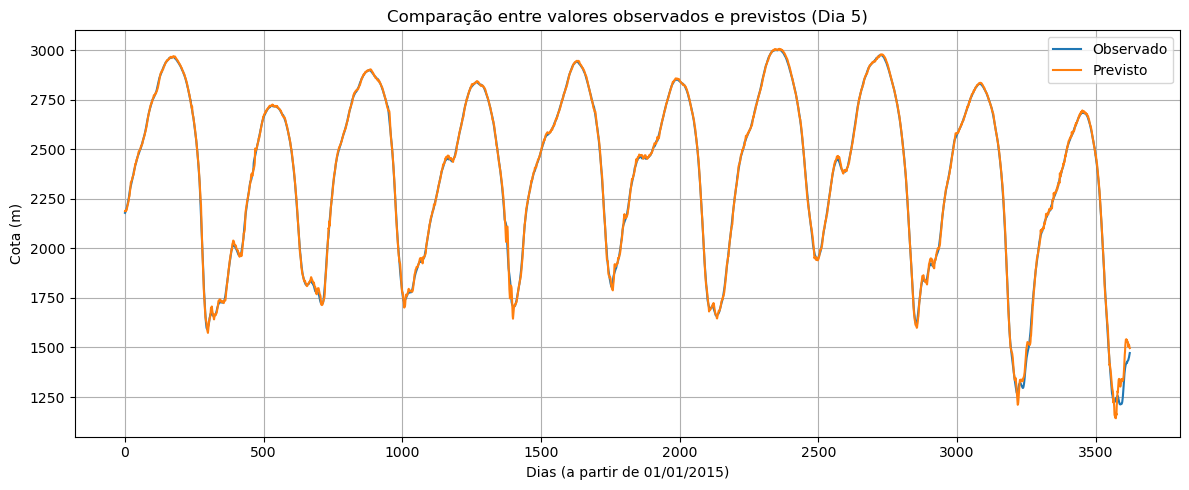

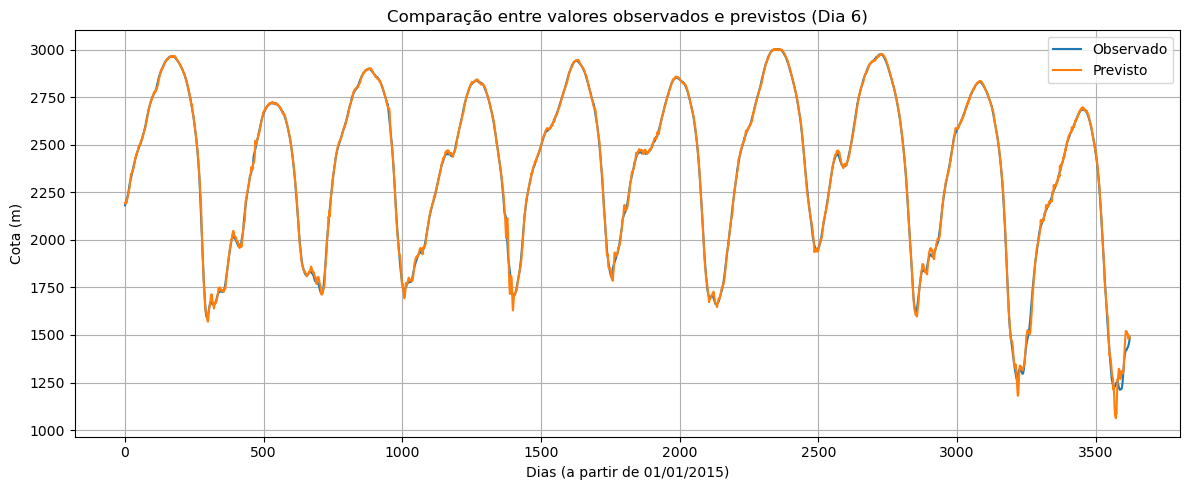

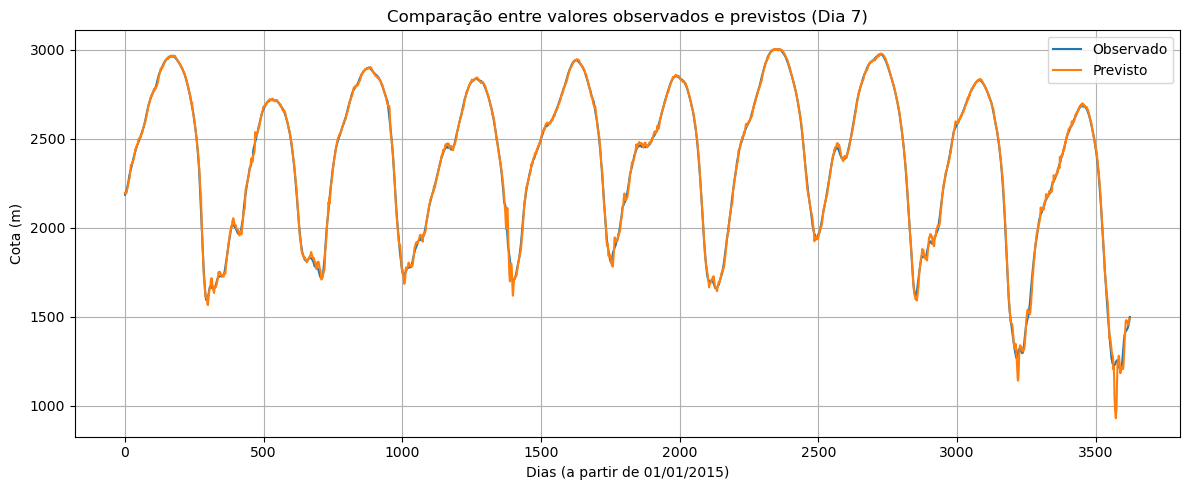

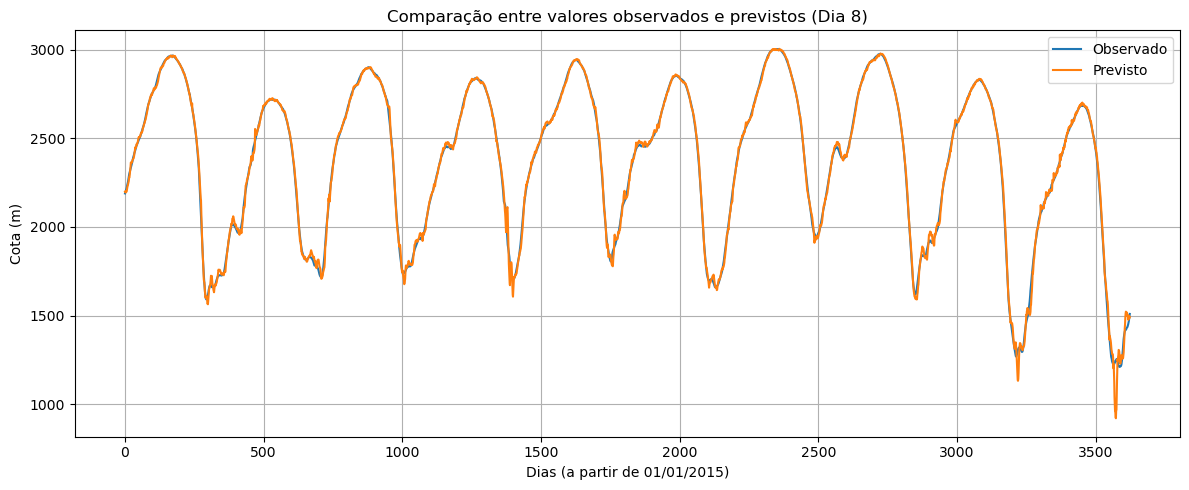

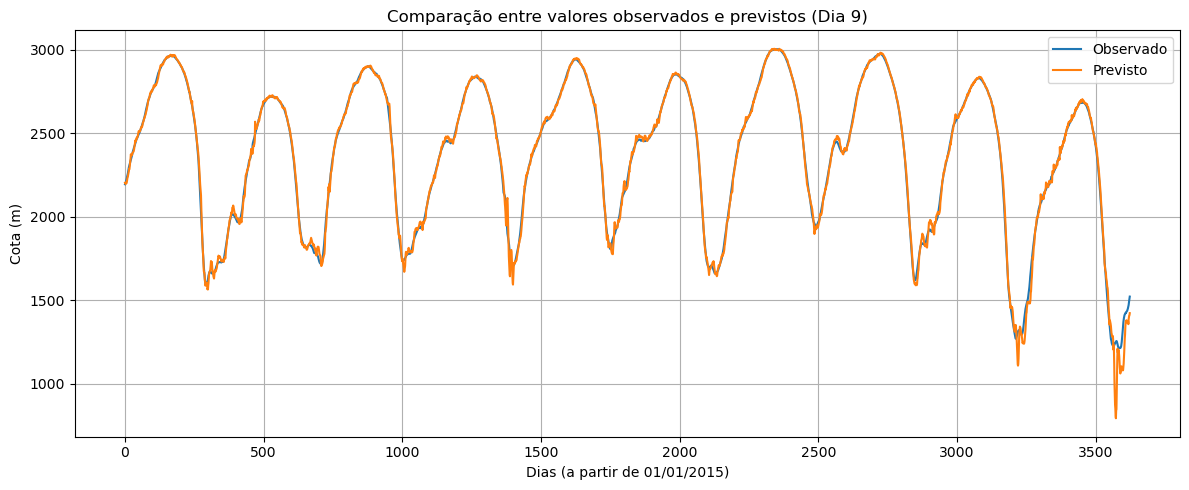

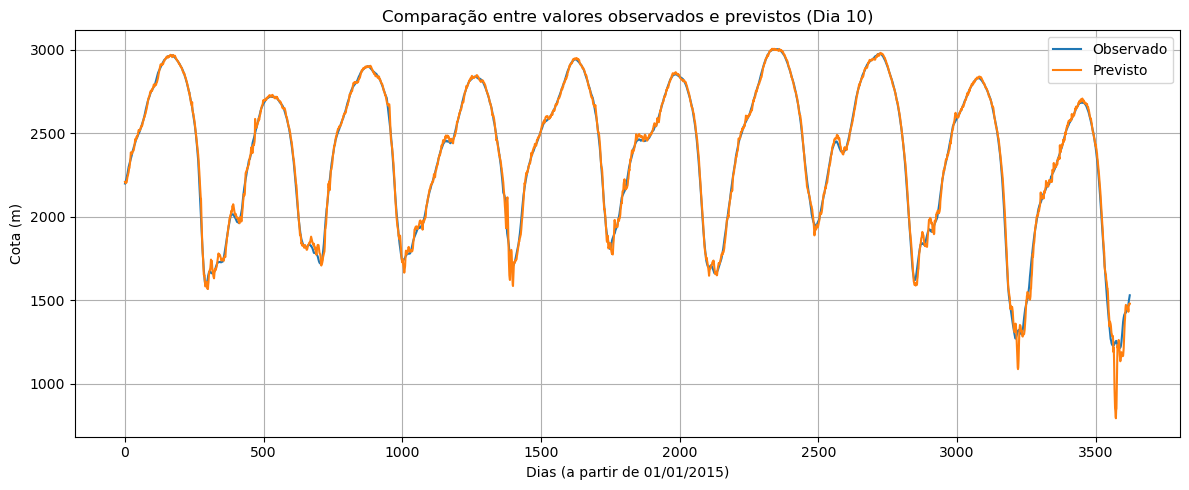

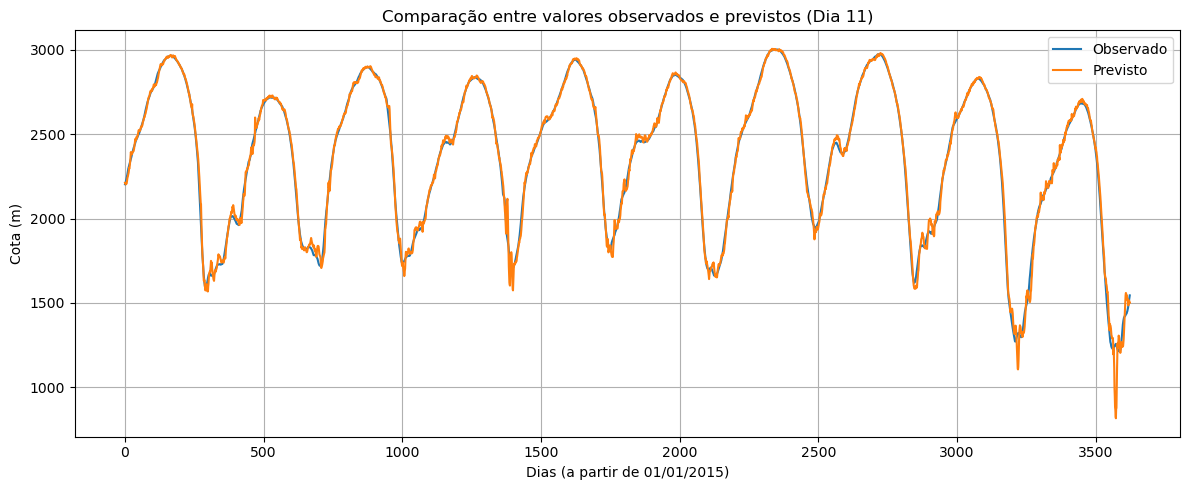

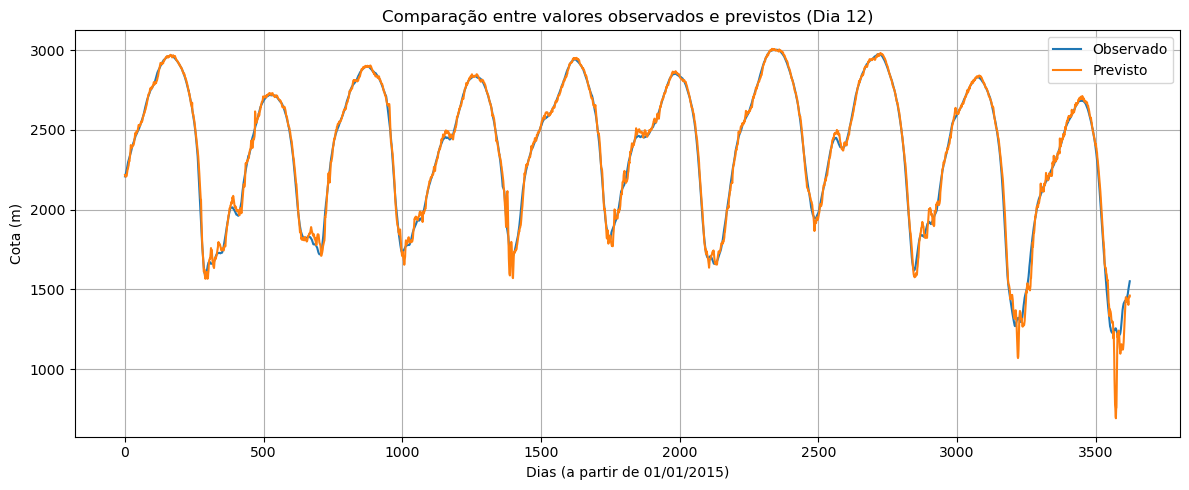

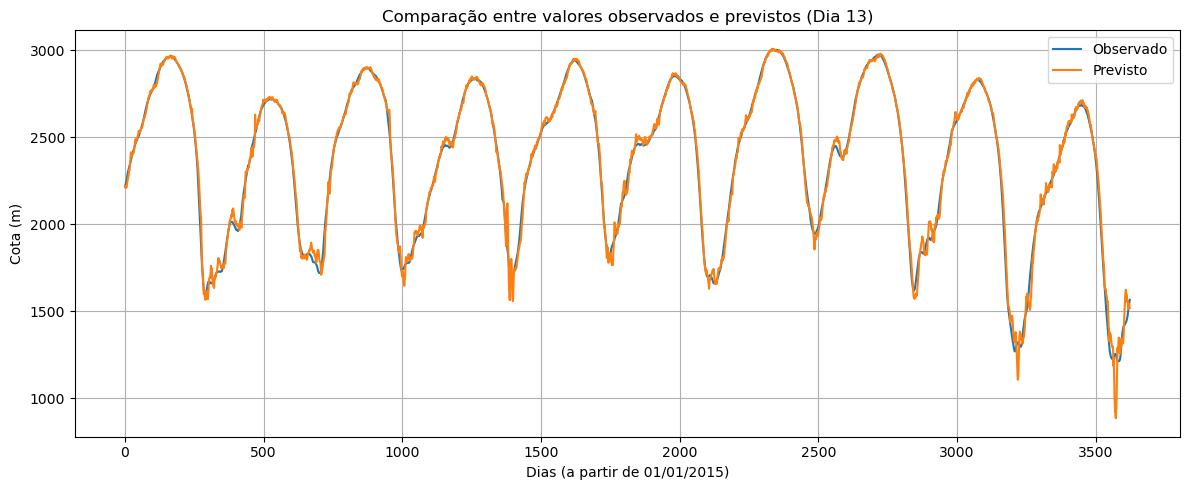

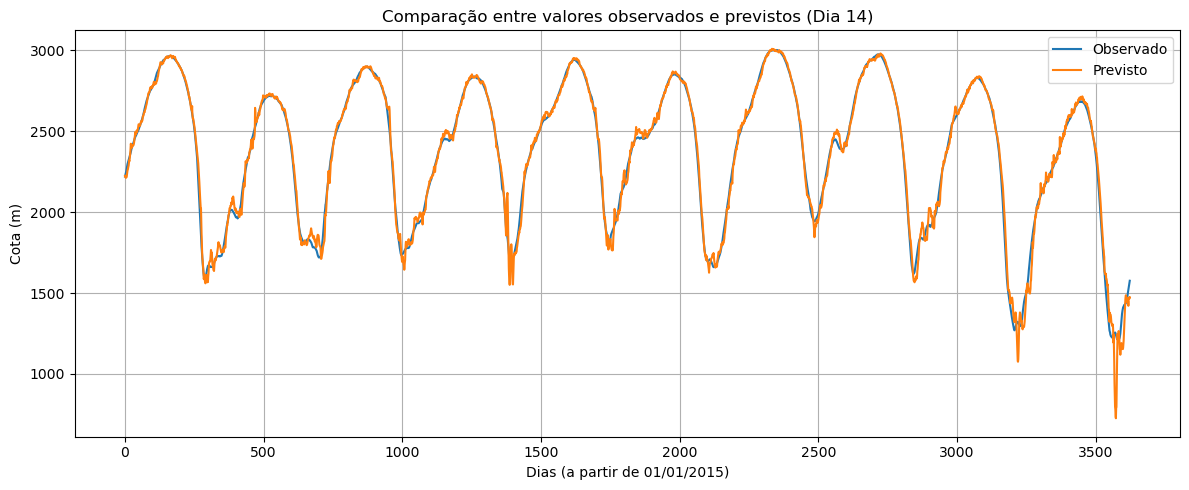

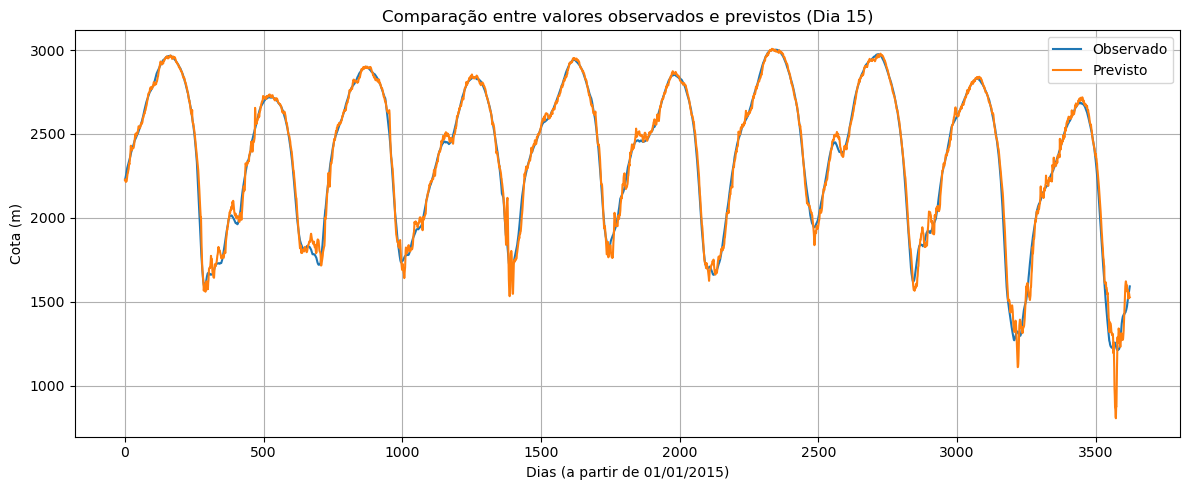

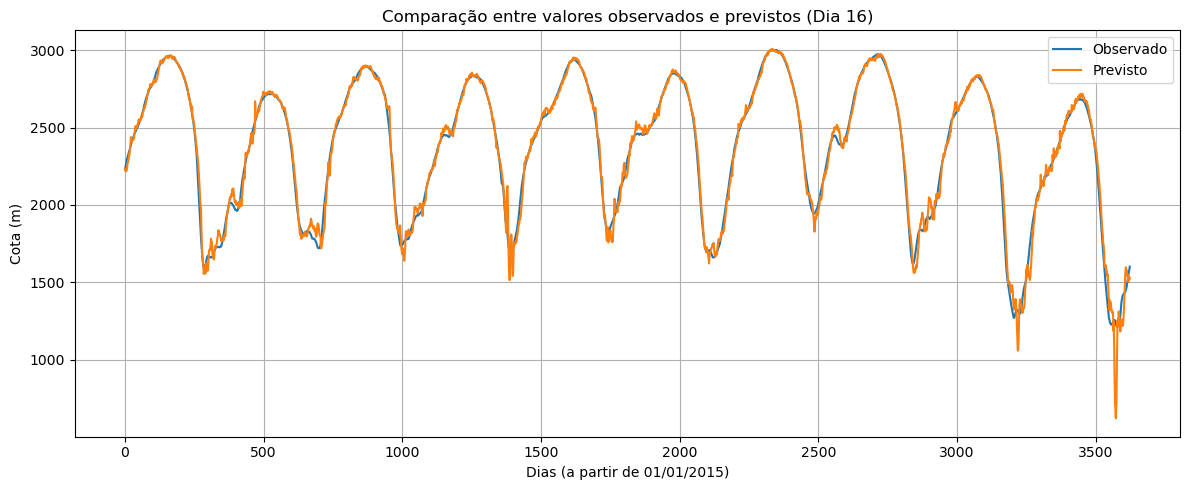

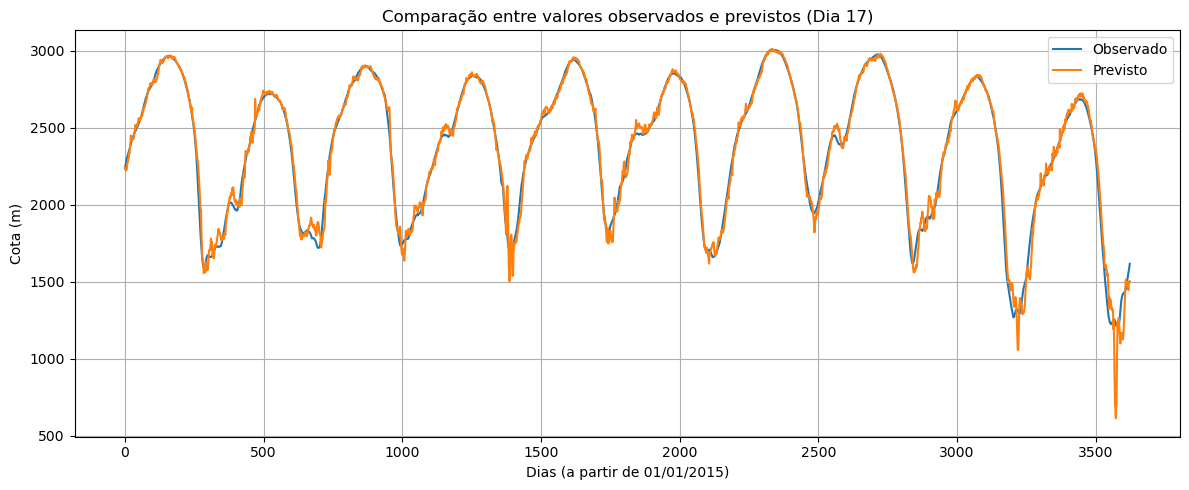

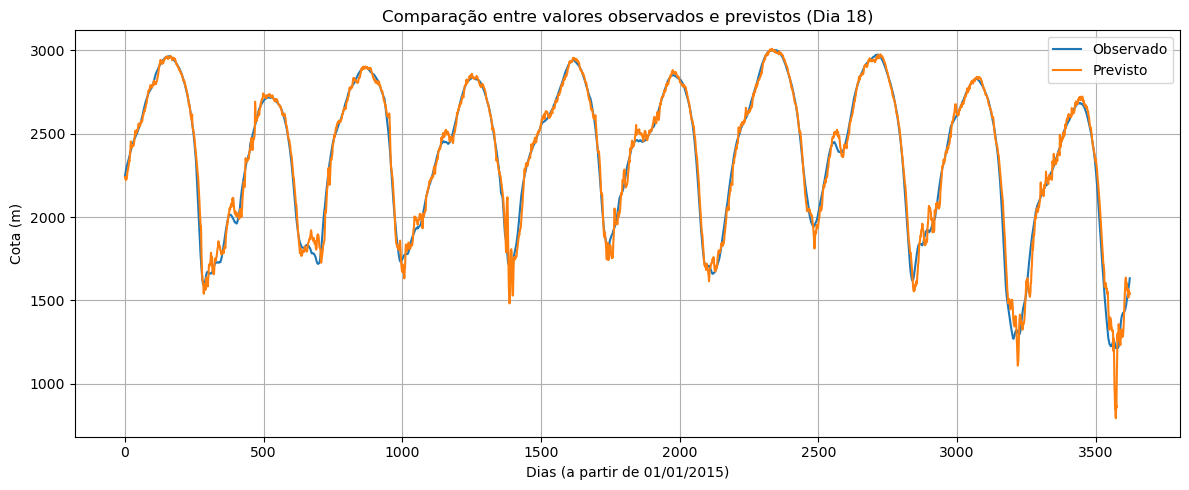

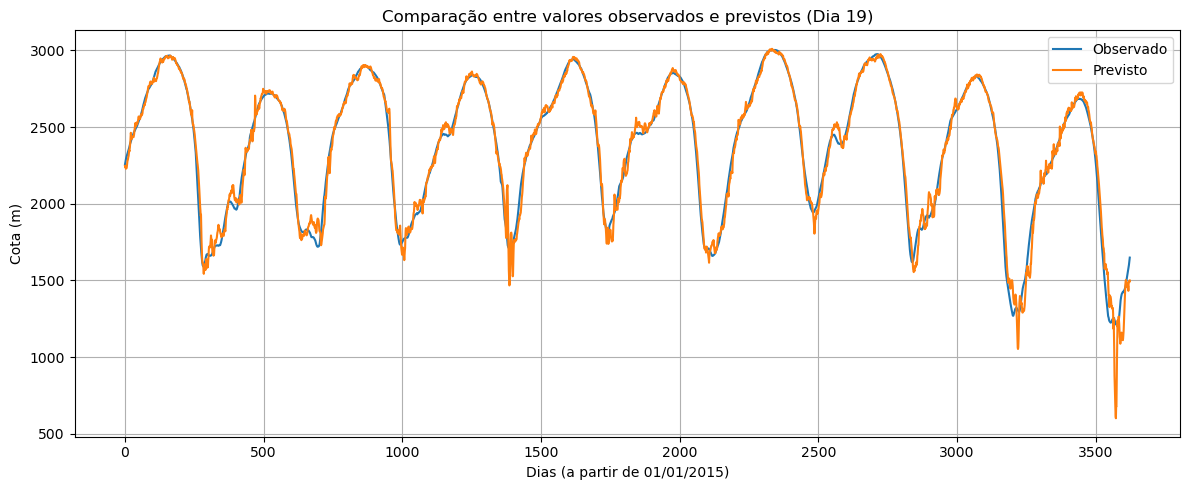

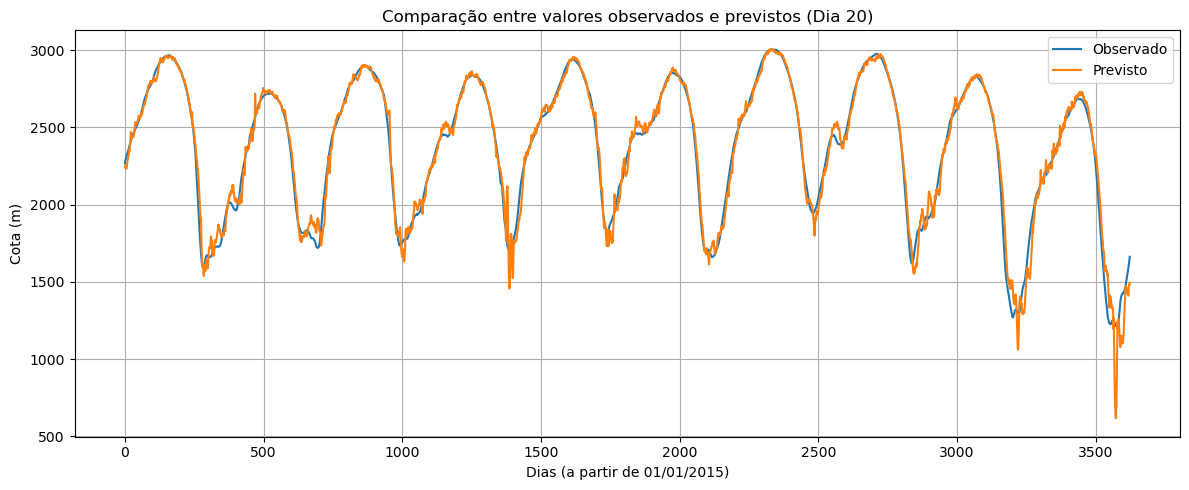

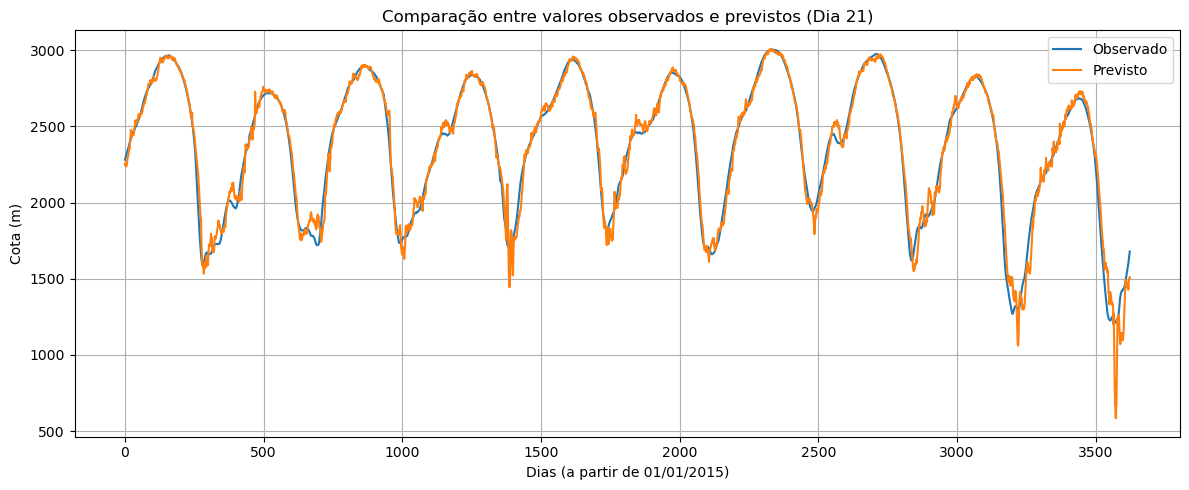

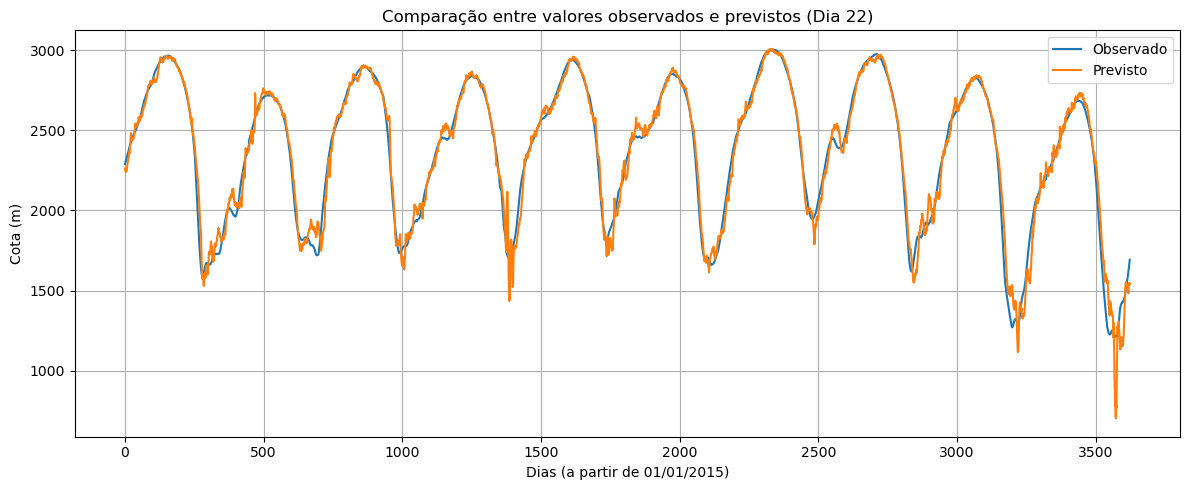

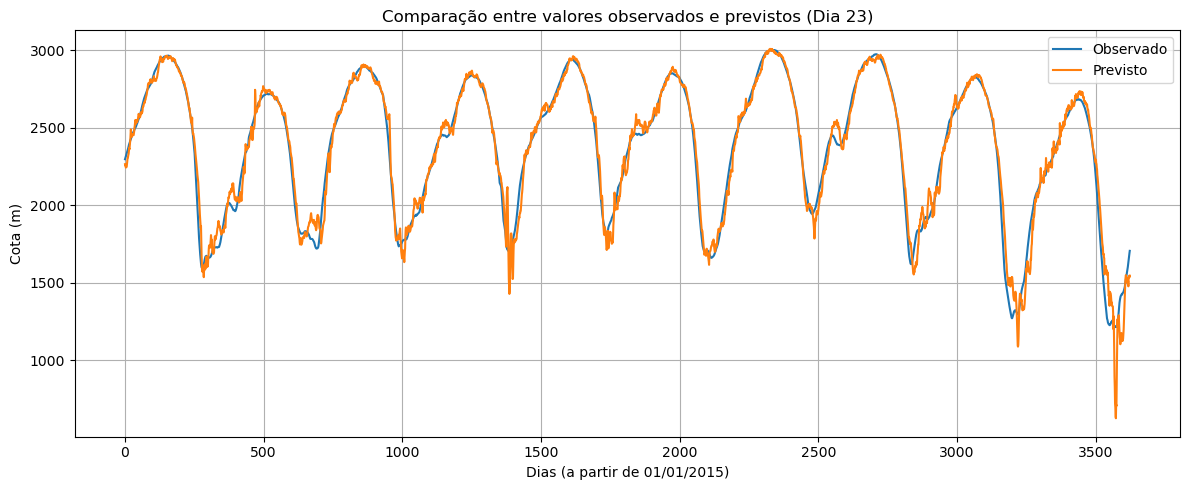

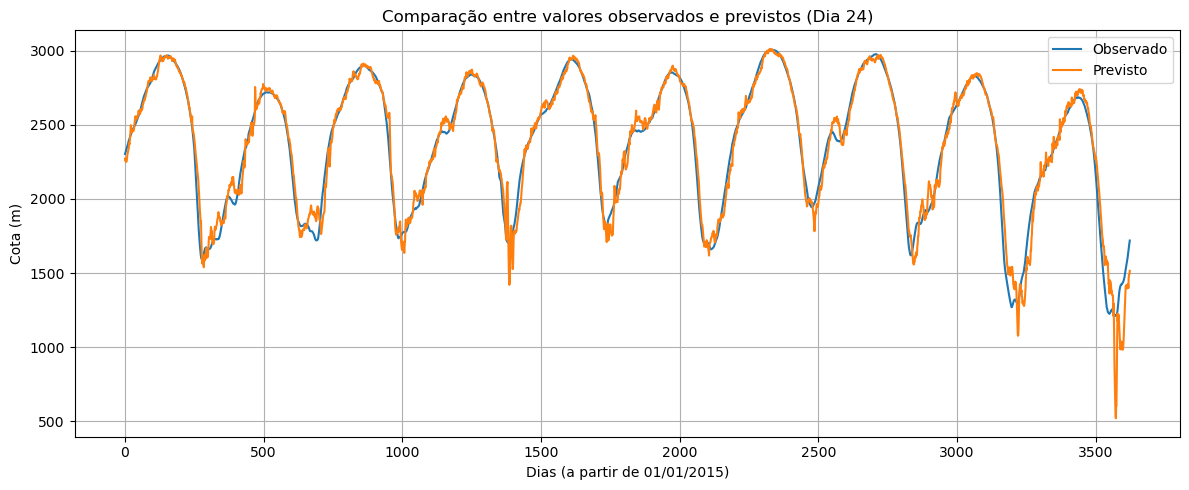

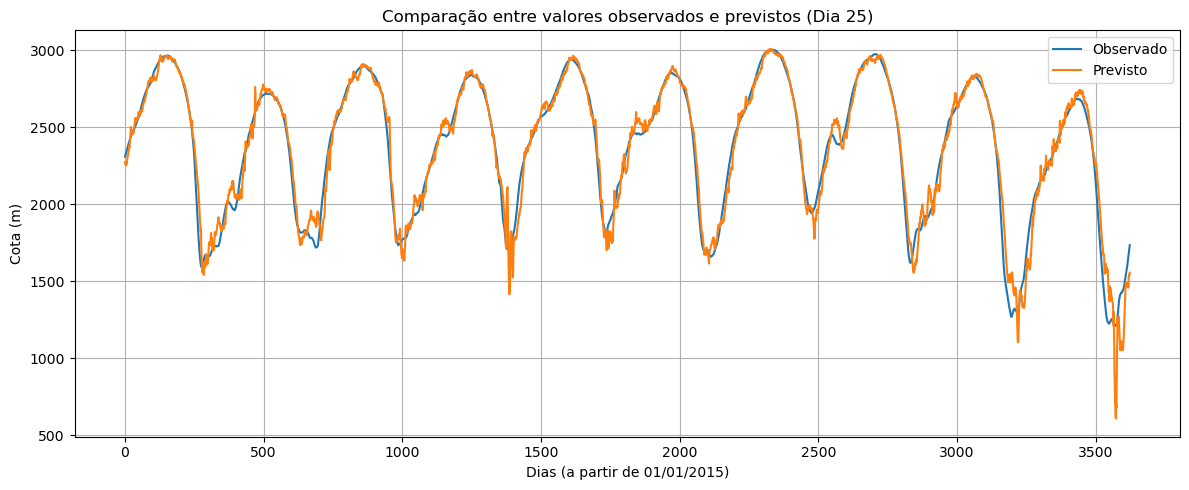

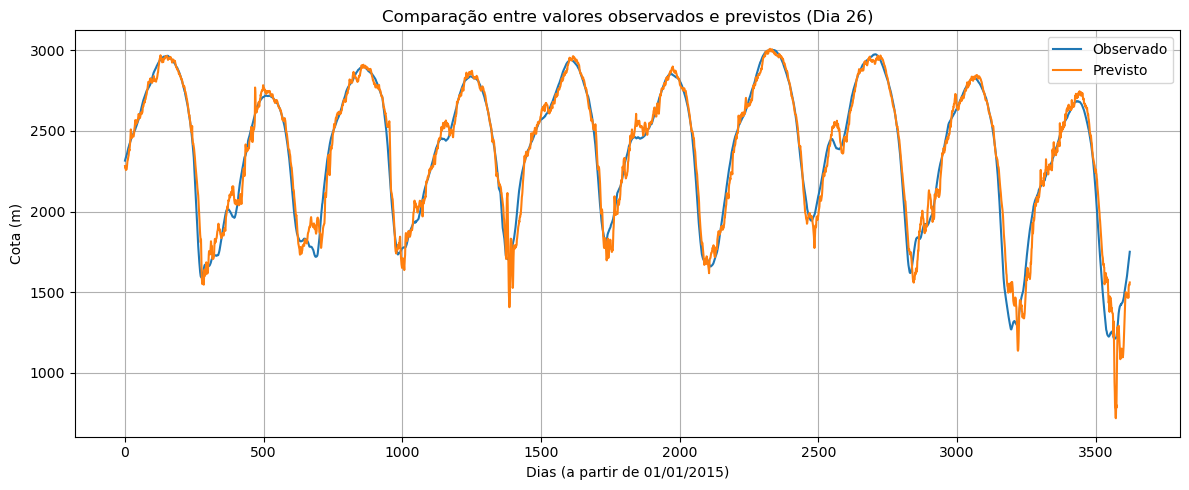

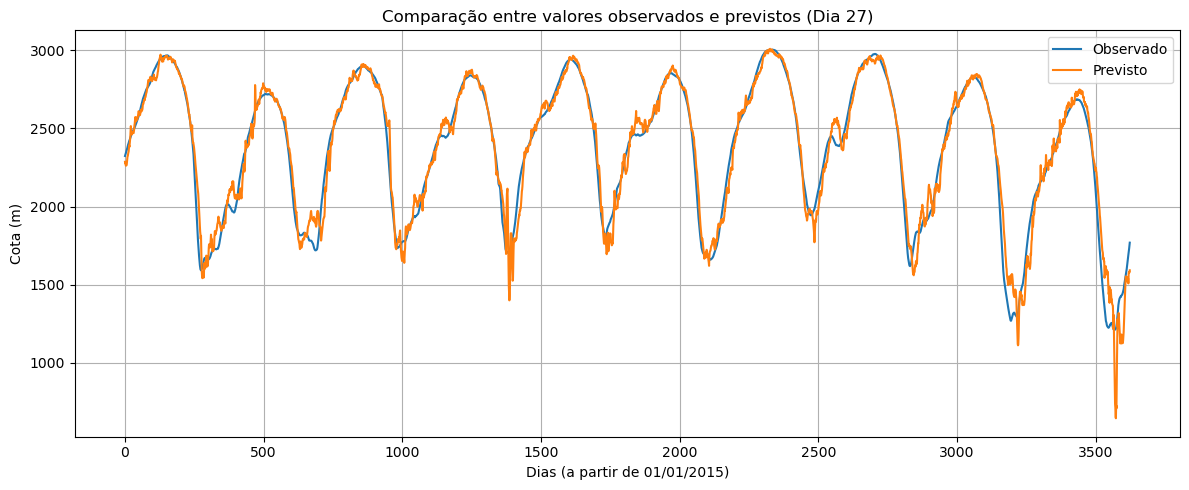

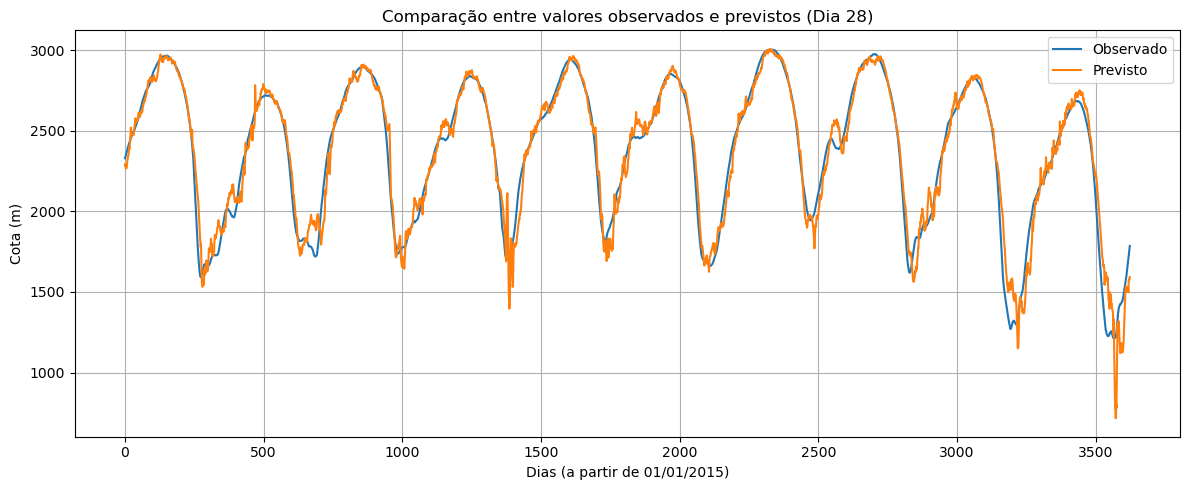

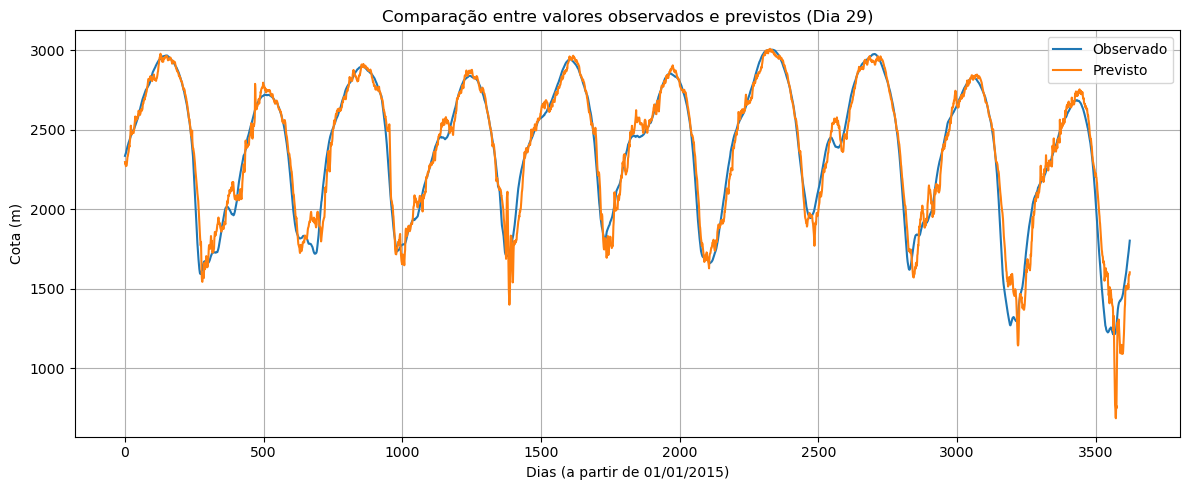

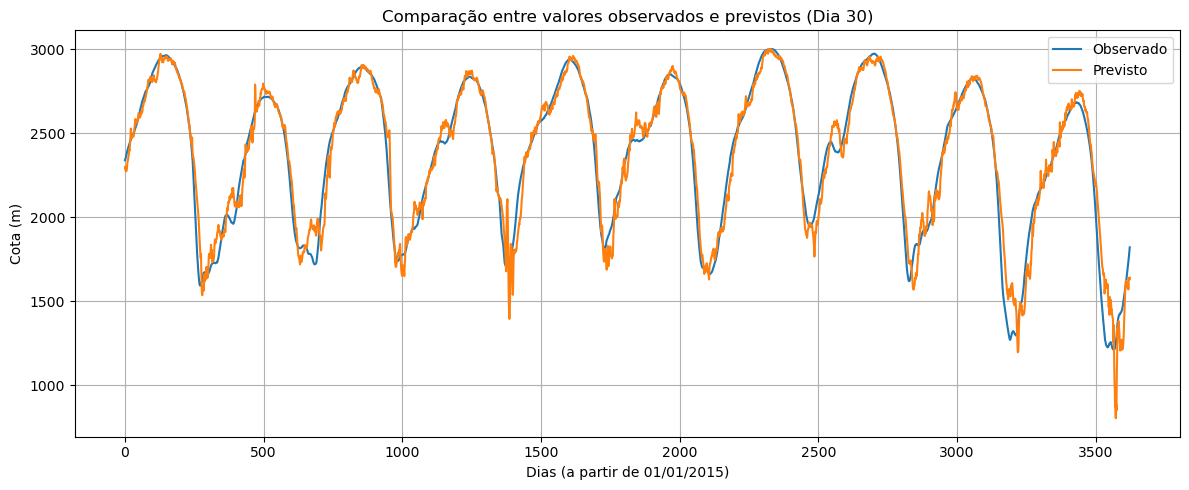

In [ ]:
for i in range(steps):
    plt.figure(figsize=(12, 5))
    plt.plot(y_test_inv[:,i], label='Observado')
    plt.plot(pred_inv[:,i], label='Previsto')
    plt.xlabel('Dias (a partir de 01/01/2015)')
    plt.ylabel('Cota (m)')
    plt.title(f'Comparação entre valores observados e previstos (Dia {i+1})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [10]:
r2_score(y_test_inv, pred_inv)

0.9815481105708077